In [ ]:
# Download & unzip all neccesary data from propedia
!pip install biopython sparse
!wget http://bioinfo.dcc.ufmg.br/propedia2/public/download/complex.csv
!wget http://bioinfo.dcc.ufmg.br/propedia2/public/download/complex2_3.zip
!wget http://bioinfo.dcc.ufmg.br/propedia2/public/download/sequences2_3.zip
!unzip -qq /content/complex2_3.zip
!unzip -qq /content/sequences2_3.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 4.2 MB/s eta 0:00:00
--2024-08-09 21:00:31--  http://bioinfo.dcc.ufmg.br/propedia2/public/download/complex.csv
Resolving bioinfo.dcc.ufmg.br (bioinfo.dcc.ufmg.br)... 150.164.203.91
Connecting to bioinfo.dcc.ufmg.br (bioinfo.dcc.ufmg.br)|150.164.203.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11717752 (11M) [text/csv]
Saving to: ‘complex.csv’

complex.csv         100%[===================>]  11.17M  5.99MB/s    in 1.9s    

2024-08-09 21:00:33 (5.99 MB/s) - ‘complex.csv’ saved [11717752/11717752]

--2024-08-09 21:00:33--  http://bioinfo.dcc.ufmg.br/propedia2/public/download/complex2_3.zip
Resolving bioinfo.dcc.ufmg.br (bioinfo.dcc.ufmg.br)... 150.164.203.91
Connecting to bioinfo.dcc.ufmg.br (bioinfo.dcc.ufmg.br)|150.164.203.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2524597712 (2.4G) [appli

In [ ]:
#@title Generate sequence/contact data
# Collect as many sequences as possible from propedia
# Get their sequences and contact maps

import os
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt

proteins = []
peptides = []
contacts = np.zeros((49297, 52, 770))
CUTOFF = 12.0
maxPepLen = 50
maxProLen = 768
failed = 0

with os.scandir('./complex') as it:
  for entry in tqdm(it):
    if entry.name.endswith(".pdb") and entry.is_file():
        # Extract pdb id and chains
        id, pepchain, prochain = entry.name.split('.')[0].split('_')

        # Get peptide sequence
        for record in SeqIO.parse(f"./peptide/{id}_{pepchain}.fasta", "fasta"):
          pep_seq = str(record.seq)

        # Get protein sequence
        for record in SeqIO.parse(f"./receptor/{id}_{prochain}.fasta", "fasta"):
          pro_seq = str(record.seq)

        # Skip non-canonical amino acids
        if 'X' in pep_seq or 'X' in pro_seq or len(pro_seq) > maxProLen:
          continue

        # Get pdb
        parser = PDBParser()
        structure = parser.get_structure('pdb', f'./complex/{entry.name}')
        pep_chain = structure[0][pepchain]
        pro_chain = structure[0][prochain]

        # Select chains
        pep_residues = [r for r in pep_chain.get_residues()]
        rec_residues = [r for r in pro_chain.get_residues()]

        # Skip if pdb sequence leng is not fasta sequence len
        if len(list(pep_chain.get_residues())) != len(pep_seq): continue
        if len(list(pro_chain.get_residues())) != len(pro_seq): continue

        # Get binary contact matrix
        try:
          distances = np.zeros((maxPepLen, maxProLen))
          for x in range(min(len(pep_seq), maxPepLen)):
            for y in range(min(len(pro_seq), maxProLen)):
              one = pep_residues[x]['CA'].get_coord()
              two = rec_residues[y]['CA'].get_coord()
              d = np.linalg.norm(one-two)
              if d <= CUTOFF:
                distances[x, y] = 1
              else:
                distances[x, y] = 0
        except:
          failed += 1
          print(failed)
          continue

        # Pad the out side of the matrix with 0's (to account for bos/eos)
        distances = np.pad(distances, 1, 'constant', constant_values=(0))

        if len(pro_seq) <= maxProLen and distances.sum() > 0:
          peptides.append(pep_seq)
          proteins.append(pro_seq)
          contacts[len(peptides)-1] = distances

29it [00:01, 25.05it/s]

1


67it [00:03, 19.02it/s]

2


371it [00:14, 48.36it/s]

3


419it [00:15, 51.44it/s]

4


547it [00:19, 36.58it/s]

5


648it [00:23, 29.57it/s]

6


886it [00:34, 17.89it/s]

7


895it [00:34, 26.45it/s]

8


993it [00:37, 37.83it/s]

9


1007it [00:38, 32.65it/s]

10


1037it [00:38, 46.54it/s]

11


1043it [00:38, 37.65it/s]

12


1064it [00:39, 44.42it/s]

13


1155it [00:41, 59.30it/s]

14


1191it [00:43, 40.29it/s]

15


1207it [00:44, 16.31it/s]

16


1292it [00:48, 25.39it/s]

17


1329it [00:50, 19.90it/s]

18


1561it [01:01, 28.58it/s]

19


1590it [01:02, 29.23it/s]

20


1622it [01:04, 26.10it/s]

21


1655it [01:05, 22.03it/s]

22


1678it [01:06, 38.14it/s]

23


1918it [01:20, 36.50it/s]

24


2198it [01:33, 31.02it/s]

25
26


2435it [01:45, 29.78it/s]

27


2449it [01:45, 27.28it/s]

28


2473it [01:47, 23.79it/s]

29


2527it [01:49, 24.15it/s]

30


2556it [01:50, 23.76it/s]

31


2632it [01:53, 35.48it/s]

32


2675it [01:55, 42.15it/s]

33


2873it [02:01, 32.76it/s]

34


3035it [02:08, 26.38it/s]

35
36


3275it [02:20, 18.05it/s]

37


3354it [02:22, 39.37it/s]

38


3529it [02:31, 28.53it/s]

39


3610it [02:38, 23.17it/s]

40


3734it [02:42, 30.67it/s]

41


3850it [02:46, 20.16it/s]

42


3887it [02:46, 43.12it/s]

43


3963it [02:49, 36.56it/s]

44


4126it [02:56, 25.22it/s]

45


4275it [03:04, 15.18it/s]

46


4363it [03:08, 37.65it/s]

47


4443it [03:12, 17.83it/s]

48


4469it [03:13, 30.47it/s]

49


4575it [03:17, 26.03it/s]

50


4737it [03:24, 33.78it/s]

51


5262it [03:43, 25.86it/s]

52


5544it [03:56, 19.23it/s]

53


5781it [04:06, 29.92it/s]

54


6024it [04:17, 55.00it/s]

55


6169it [04:22, 33.61it/s]

56


6277it [04:25, 38.37it/s]

57


6301it [04:26, 24.50it/s]

58


6398it [04:29, 31.06it/s]

59


6452it [04:31, 40.99it/s]

60


6480it [04:33, 30.29it/s]

61


6526it [04:35, 23.23it/s]

62


6609it [04:40, 31.91it/s]

63


6727it [04:44, 53.33it/s]

64


6797it [04:46, 45.32it/s]

65


6833it [04:47, 48.73it/s]

66


7205it [05:00, 20.62it/s]

67


7313it [05:05, 16.63it/s]

68


7403it [05:08, 39.24it/s]

69


8015it [05:32, 26.90it/s]

70


8273it [05:39, 45.79it/s]

71


8893it [06:04, 34.45it/s]

72


8909it [06:04, 28.55it/s]

73


9117it [06:15, 15.81it/s]

74


9532it [06:30, 44.12it/s]

75


9538it [06:30, 33.09it/s]

76


9564it [06:31, 45.80it/s]

77


9606it [06:33, 30.98it/s]

78


9864it [06:46, 24.95it/s]

79


10097it [06:54, 19.64it/s]

80


10206it [06:59, 24.88it/s]

81


10302it [07:04, 32.58it/s]

82


10418it [07:08, 27.37it/s]

83


10662it [07:17, 32.51it/s]

84


10679it [07:17, 29.45it/s]

85


10850it [07:26, 14.97it/s]

86


11200it [07:43, 25.45it/s]

87


11245it [07:45, 33.53it/s]

88


11262it [07:46, 33.29it/s]

89
90


11306it [07:47, 36.54it/s]

91


11583it [07:59, 29.31it/s]

92


11842it [08:06, 35.45it/s]

93


12379it [08:29, 26.77it/s]

94


12449it [08:31, 53.76it/s]

95


12513it [08:33, 39.37it/s]

96


12670it [08:40, 21.89it/s]

97


12735it [08:42, 21.17it/s]

98


12827it [08:46, 37.47it/s]

99


13041it [08:54, 45.68it/s]

100


13151it [08:58, 41.40it/s]

101


13209it [08:59, 36.66it/s]

102


13377it [09:07, 18.37it/s]

103


13854it [09:24, 38.64it/s]

104


13918it [09:26, 20.03it/s]

105


14004it [09:31, 17.86it/s]

106


14180it [09:40, 24.38it/s]

107


14429it [09:48, 46.85it/s]

108


14684it [10:01, 35.84it/s]

109


15041it [10:15, 29.72it/s]

110


15302it [10:28, 23.29it/s]

111


15781it [10:46, 15.01it/s]

112


16074it [10:59, 49.26it/s]

113


16107it [11:00, 39.83it/s]

114


16337it [11:09, 22.07it/s]

115


16385it [11:12, 22.02it/s]

116


16410it [11:13, 37.14it/s]

117


16649it [11:24, 26.53it/s]

118
119


16753it [11:27, 47.18it/s]

120


17443it [11:57, 20.54it/s]

121


17456it [11:57, 21.38it/s]

122


17512it [11:59, 42.77it/s]

123


17607it [12:03, 28.59it/s]

124


18026it [12:19, 54.04it/s]

125


18039it [12:20, 40.75it/s]

126


18044it [12:20, 38.56it/s]

127


18261it [12:32, 20.66it/s]

128


18342it [12:35, 19.63it/s]

129


18455it [12:39, 22.69it/s]

130


18484it [12:40, 37.09it/s]

131


18590it [12:43, 32.90it/s]

132


18647it [12:45, 34.78it/s]

133


18685it [12:47, 16.78it/s]

134


19107it [13:05, 27.99it/s]

135


19260it [13:12, 27.84it/s]

136


19335it [13:16, 26.29it/s]

137


19369it [13:17, 26.27it/s]

138


19435it [13:20, 18.23it/s]

139


19467it [13:21, 34.72it/s]

140


19914it [13:39, 28.72it/s]

141


20602it [14:09, 16.40it/s]

142


20753it [14:17, 28.67it/s]

143


20768it [14:18, 30.95it/s]

144
145


20794it [14:18, 61.12it/s]

146


20943it [14:23, 44.45it/s]

147


20962it [14:24, 38.38it/s]

148


21332it [14:41, 25.81it/s]

149


21368it [14:43, 24.76it/s]

150


21634it [14:54, 15.42it/s]

151


21806it [15:01, 20.43it/s]

152


21878it [15:04, 41.06it/s]

153


21949it [15:06, 35.34it/s]

154


22087it [15:11, 42.55it/s]

155


22225it [15:14, 31.36it/s]

156


22285it [15:18, 19.21it/s]

157


22531it [15:30, 28.55it/s]

158


22734it [15:37, 45.59it/s]

159


22813it [15:39, 26.18it/s]

160


22962it [15:47, 37.03it/s]

161


22993it [15:49, 18.38it/s]

162


23040it [15:50, 31.16it/s]

163


23132it [15:54, 51.42it/s]

164


23209it [15:57, 38.03it/s]

165


23401it [16:03, 35.65it/s]

166


23435it [16:05, 20.66it/s]

167


23537it [16:11, 17.67it/s]

168
169


23604it [16:13, 21.82it/s]

170


23676it [16:17, 15.30it/s]

171


23899it [16:23, 34.37it/s]

172


24139it [16:32, 23.09it/s]

173


24174it [16:33, 29.67it/s]

174


24202it [16:35, 18.99it/s]

175


24292it [16:40, 20.75it/s]

176


24378it [16:44, 22.65it/s]

177


24498it [16:47, 47.99it/s]

178


24662it [16:56, 14.55it/s]

179


24710it [17:00, 10.19it/s]

180


24801it [17:05, 16.45it/s]

181


24987it [17:11, 27.23it/s]

182


25052it [17:13, 46.01it/s]

183


25118it [17:15, 42.79it/s]

184


25302it [17:24, 18.63it/s]

185


25674it [17:38, 30.10it/s]

186


25693it [17:39, 37.64it/s]

187


26006it [17:54, 22.83it/s]

188


26146it [17:59, 30.18it/s]

189


26159it [17:59, 33.77it/s]

190


26173it [18:00, 35.21it/s]

191


26462it [18:15,  7.27it/s]

192


26737it [18:26, 33.12it/s]

193


26807it [18:28, 30.24it/s]

194


26866it [18:30, 31.27it/s]

195


26889it [18:32, 22.32it/s]

196


26972it [18:36, 19.12it/s]

197


27577it [19:06, 18.53it/s]

198
199


27781it [19:14, 25.39it/s]

200


27828it [19:16, 52.31it/s]

201


27985it [19:21, 51.01it/s]

202


28141it [19:26, 28.36it/s]

203


28452it [19:40, 25.16it/s]

204


28479it [19:41, 30.39it/s]

205


28543it [19:43, 38.43it/s]

206


28589it [19:45, 32.74it/s]

207


28636it [19:46, 34.81it/s]

208


28803it [19:54, 27.48it/s]

209


28849it [19:56, 30.30it/s]

210


29121it [20:06, 29.27it/s]

211


29226it [20:09, 28.37it/s]

212


29265it [20:11, 29.73it/s]

213


29378it [20:16, 18.66it/s]

214


29612it [20:27, 31.03it/s]

215


29746it [20:31, 51.27it/s]

216


29771it [20:32, 18.71it/s]

217


29890it [20:36, 35.48it/s]

218


29919it [20:38, 27.38it/s]

219


29985it [20:41, 20.38it/s]

220


30042it [20:45,  9.36it/s]

221


30377it [20:55, 48.33it/s]

222


30476it [20:58, 30.16it/s]

223


30509it [20:59, 50.94it/s]

224


30568it [21:01, 42.27it/s]

225


30618it [21:02, 29.18it/s]

226


30707it [21:06, 15.49it/s]

227


31633it [21:45, 12.25it/s]

228


31758it [21:52, 21.87it/s]

229
230


31910it [21:58, 27.18it/s]

231


32233it [22:12, 23.94it/s]

232


32678it [22:33, 27.76it/s]

233


32887it [22:40, 29.80it/s]

234


33102it [22:49, 24.34it/s]

235


33159it [22:52, 21.87it/s]

236


33225it [22:56, 14.10it/s]

237


33266it [22:58, 17.21it/s]

238


33286it [22:59, 22.26it/s]

239


33629it [23:14, 26.20it/s]

240


33751it [23:20, 17.94it/s]

241


33949it [23:28, 33.07it/s]

242


33961it [23:28, 32.15it/s]

243


34016it [23:31, 22.55it/s]

244


34390it [23:47, 36.88it/s]

245


34934it [24:08, 22.71it/s]

246


34990it [24:10, 20.74it/s]

247


35205it [24:18, 31.69it/s]

248


35279it [24:20, 34.71it/s]

249


35710it [24:39, 26.55it/s]

250


35954it [24:46, 38.81it/s]

251


36027it [24:48, 35.35it/s]

252


36176it [24:56, 15.65it/s]

253


36347it [25:04, 26.78it/s]

254


36435it [25:06, 40.00it/s]

255


36573it [25:11, 30.82it/s]

256


37236it [25:36, 32.89it/s]

257


37455it [25:48, 16.34it/s]

258


37592it [25:53, 38.57it/s]

259


37735it [25:58, 24.12it/s]

260


38329it [26:22, 36.19it/s]

261


38560it [26:32, 27.56it/s]

262


38860it [26:43, 55.22it/s]

263
264


39090it [26:50, 50.16it/s]

265


39183it [26:55, 18.50it/s]

266


39212it [26:56, 21.34it/s]

267


39665it [27:13, 46.78it/s]

268


39720it [27:15, 29.90it/s]

269


39795it [27:18, 20.11it/s]

270


39850it [27:21, 13.70it/s]

271


39918it [27:25, 30.65it/s]

272


39975it [27:28, 16.47it/s]

273


40085it [27:32, 40.38it/s]

274


40181it [27:36, 31.74it/s]

275


40345it [27:42, 12.55it/s]

276


40481it [27:49, 22.67it/s]

277


40552it [27:53, 16.64it/s]

278


40649it [27:57, 27.46it/s]

279


40910it [28:05, 30.82it/s]

280


41031it [28:14, 14.05it/s]

281


41143it [28:20, 26.87it/s]

282


41368it [28:27, 32.48it/s]

283


41472it [28:30, 23.05it/s]

284


41498it [28:31, 30.67it/s]

285


41814it [28:44, 28.13it/s]

286


41997it [28:48, 51.35it/s]

287


42038it [28:50, 29.86it/s]

288


42243it [28:56, 30.10it/s]

289


42321it [29:00, 25.88it/s]

290


42358it [29:01, 29.12it/s]

291


42386it [29:02, 30.05it/s]

292


42517it [29:09, 15.66it/s]

293


42629it [29:13, 37.56it/s]

294


42723it [29:17, 34.11it/s]

295


42798it [29:18, 43.81it/s]

296


42901it [29:22, 35.08it/s]

297
298


42968it [29:26, 16.04it/s]

299


43270it [29:40, 30.99it/s]

300


43410it [29:44, 28.29it/s]

301


43479it [29:47, 23.75it/s]

302


43534it [29:48, 60.64it/s]

303
304


43650it [29:55, 18.66it/s]

305


43777it [30:01, 46.55it/s]

306


43919it [30:06, 40.28it/s]

307


44007it [30:09, 28.02it/s]

308


44054it [30:10, 34.58it/s]

309


44327it [30:25, 14.76it/s]

310


44825it [30:45, 40.64it/s]

311


45087it [30:58, 24.42it/s]

312


45330it [31:09, 18.24it/s]

313


45369it [31:11, 25.66it/s]

314


45463it [31:15, 23.81it/s]

315


45484it [31:16, 29.12it/s]

316


45541it [31:18, 36.23it/s]

317


45745it [31:23, 46.10it/s]

318


45865it [31:27, 28.34it/s]

319


46088it [31:39, 27.46it/s]

320
321


46112it [31:40, 21.27it/s]

322


46646it [32:06, 29.13it/s]

323


46896it [32:15, 40.30it/s]

324


46922it [32:15, 45.58it/s]

325


46927it [32:16, 33.10it/s]

326


47084it [32:22, 16.42it/s]

327


47226it [32:30, 19.97it/s]

328


47260it [32:32, 29.42it/s]

329


47316it [32:35, 21.70it/s]

330


47511it [32:41, 48.40it/s]

331


47695it [32:48, 17.24it/s]

332


47771it [32:52, 21.34it/s]

333


47836it [32:55, 25.88it/s]

334


48209it [33:08, 29.50it/s]

335


48270it [33:11, 24.90it/s]

336


48752it [33:31, 39.66it/s]

337


48782it [33:31, 54.57it/s]

338


48875it [33:35, 24.29it/s]

339


48888it [33:35, 31.44it/s]

340
341


49099it [33:45, 24.58it/s]

342


49297it [33:52, 24.25it/s]


In [ ]:
contacts = contacts[:len(peptides)]
print(len(peptides))
print(len(proteins))
contacts.shape

17287
17287


(17287, 52, 770)

In [2]:
# Remove duplicate peptide/protein pairs.
import sparse
import pandas as pd
df = pd.DataFrame({
    'sequence': peptides,
    'receptor': proteins,
    'contacts': list(range(contacts.shape[0]))
})
df = df.drop_duplicates(subset=["sequence", "receptor"]).reset_index()
contacts = contacts[df['contacts'].tolist()]

proteins = df['receptor'].tolist()
peptides = df['sequence'].tolist()

print(len(proteins))
print(len(peptides))
print(contacts.shape)

11186
11186
(11186, 52, 770)


In [1]:
#@title If sequence/contact data is already generated, just load it directly
# Load the protein/peptide pairs into lists
import sparse
import numpy as np
proteins = []
peptides = []
with open('/content/8_8_24_sequence_pairs_768.txt', 'r') as f:
  for line in f:
    prot, pep, _ = line.split(':')
    proteins.append(prot.replace('\n', ''))
    peptides.append(pep.replace('\n', ''))
f.close()

# Load the distance matrices for all pairs
sparse_contacts = sparse.load_npz('/content/8_8_24_contacts_768.npz')
sparse_contacts = sparse_contacts[:len(peptides)]
contacts = sparse_contacts.todense()

print(len(peptides))
print(len(proteins))
contacts.shape

11186
11186


(11186, 52, 770)

In [2]:
# Find the the 10% of interfaces with the lowest
# average similarity to all other interfaces

contacts_flat = contacts.sum(axis=1)

# Normalize embeddings
norms = np.linalg.norm(contacts_flat, axis=1, keepdims=True)
normalized_embeddings = contacts_flat / norms

# Compute cosine similarities matrix
cosine_similarities = np.dot(normalized_embeddings, normalized_embeddings.T)

# Fill the diagonal with NaNs to ignore self-similarity
np.fill_diagonal(cosine_similarities, np.nan)

# Compute the average cosine similarity for each embedding
average_similarities = np.nanmean(cosine_similarities, axis=1)

# Find the indices of the 10% embeddings with the lowest average similarity
# These sequences will become the validation set
num_lowest = int(len(average_similarities) * 0.1)
val_idxs = np.argsort(average_similarities)[:num_lowest]
train_idxs = np.setdiff1d(np.arange(contacts_flat.shape[0]), val_idxs)

In [3]:
# Now, remove any sequence pairs that have distance matricies
# with > 0.7 cosine similaity to any distance matrix in the validation set

from tqdm import tqdm
from sklearn.metrics.pairwise import manhattan_distances
from scipy.spatial.distance import cdist

cosine_similarities = 1 - cdist(contacts_flat[train_idxs], contacts_flat[val_idxs], metric='cosine')
max_similarities = np.max(cosine_similarities, axis=1)
train_idxs = train_idxs[np.where(max_similarities <= 0.7)[0]]

print(train_idxs.shape)

(9668,)


In [4]:
all_idxs = np.concatenate((train_idxs, val_idxs), axis=0)
contacts = contacts[all_idxs]

print(len(peptides))
print(len(proteins))
contacts.shape

11186
11186


(10786, 52, 770)

In [5]:
# Save the sequence pairs and the val indices.
with open('8_14_24_sequence_pairs_ALL.txt', 'w') as f:
  for i, pair in enumerate(zip(peptides, proteins)):
    p, P = pair
    if i in val_idxs:
      f.write(f'{P}:{p}:{1}\n')
    elif i in train_idxs:
      f.write(f'{P}:{p}:{0}\n')
f.close()

In [9]:
!wc -l /content/8_14_24_sequence_pairs_ALL.txt

10786 /content/8_14_24_sequence_pairs_ALL.txt


In [8]:
np.savez_compressed('8_14_24_contacts.npz', a=contacts)

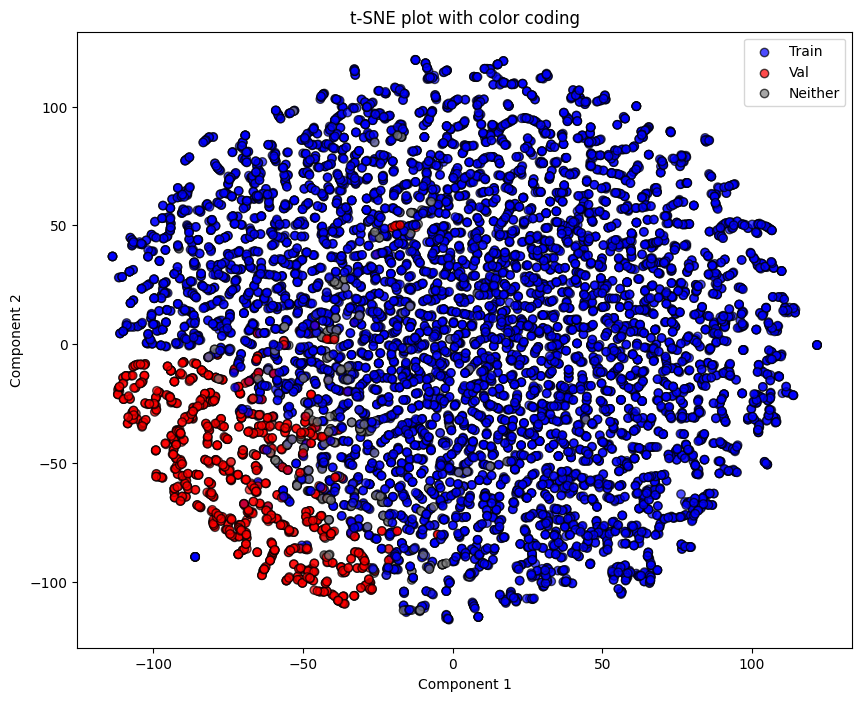

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=10, random_state=42)
data_2d = pca.fit_transform(contacts_flat)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
data_2d = tsne.fit_transform(data_2d)

# Create an array for colors
colors = np.full(contacts_flat.shape[0], 'gray')  # Default color is gray

# Assign colors based on indices
colors[train_idxs] = 'blue'
colors[val_idxs] = 'red'

# Plot the 2D t-SNE representation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=colors, edgecolor='k', alpha=0.7)
plt.title('t-SNE plot with color coding')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Add a legend
plt.scatter([], [], c='blue', edgecolor='k', alpha=0.7, label='Train')
plt.scatter([], [], c='red', edgecolor='k', alpha=0.7, label='Val')
plt.scatter([], [], c='gray', edgecolor='k', alpha=0.7, label='Neither')
plt.legend(loc='upper right')

plt.show()